In [1]:
%reload_ext autoreload
%autoreload 2

In [5]:
from src.hmm import get_likelihood
from src.test_hmm import generate_data
import numpy as np
(
    initial_conditions,
    transition_matrix,
    emission_matrix,
    _,
    observations_ind,
) = generate_data()

likelihood = get_likelihood(emission_matrix, observations_ind)
log_likelihood = np.log(likelihood)

In [3]:
from src.hmm3 import forward, smoother, estimate_transition_matrix
from src.hmm import check_converged

tolerance = 1e-4
max_iter = 10

marginal_log_likelihoods = []
n_iter = 0
converged = False

while not converged and (n_iter < max_iter):
    # Expectation
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        initial_conditions, log_likelihood, transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, transition_matrix
    )

    # Maximization
    initial_conditions = acausal_posterior[0]
    # transition_matrix = estimate_transition_matrix(
    #     causal_posterior,
    #     predictive_distribution,
    #     transition_matrix,
    #     acausal_posterior,
    # )

    # Stats
    n_iter += 1

    marginal_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = marginal_log_likelihoods[-1] - marginal_log_likelihoods[-2]
        converged, increasing = check_converged(
            marginal_log_likelihoods[-1], marginal_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {marginal_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {marginal_log_likelihoods[-1]}")

iteration 1, likelihood: -5.52629188048878
iteration 2, likelihood: -5.737131752798916, change: -0.21083987231013612
iteration 3, likelihood: -5.765385740113668, change: -0.028253987314752038
iteration 4, likelihood: -5.769207118065249, change: -0.0038213779515805513
iteration 5, likelihood: -5.769725765623484, change: -0.0005186475582350525


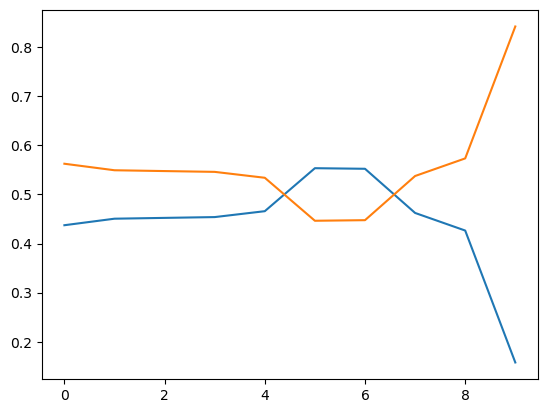

In [6]:
import matplotlib.pyplot as plt

# Expectation
causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
    initial_conditions, log_likelihood, transition_matrix
)
acausal_posterior = smoother(
    causal_posterior, predictive_distribution, transition_matrix
)
plt.plot(acausal_posterior)